In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ahmedhamada0/brain-tumor-detection")

print("Path to dataset files:", path)

path = kagglehub.dataset_download("migueldazbenito/json-notes")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-detection
Path to dataset files: /kaggle/input/json-notes


In [3]:
from ultralytics import YOLO

model = YOLO("rtdetr-l.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 63.4M/63.4M [00:00<00:00, 121MB/s]


In [4]:
annotations_path = "/kaggle/input/json-notes/annotations_all_corregido.json"
images_path = "/kaggle/input/brain-tumor-detection/Br35H-Mask-RCNN/TRAIN/"
path = "/kaggle/input/brain-tumor-detection/Br35H-Mask-RCNN/"

In [8]:
import os
import json
import cv2

def create_bbox_json(input_json, output_json):
    with open(input_json, 'r') as f:
        data = json.load(f)
    os.mkdir("/kaggle/working")
    os.mkdir("/kaggle/working/Br-35H-Mask-RCNN/")
    os.mkdir("/kaggle/working/Br-35H-Mask-RCNN/labels")
    new_data = []

    for image_info in data:
        new_image_info = {'filename': image_info, 'boxes': []}
        elemento = data[image_info]

        imagen = "/kaggle/input/brain-tumor-detection/yes/" +  image_info
        img = cv2.imread(imagen)
        height, width, channels = img.shape

        for region in elemento['regions']:
            box = {}
            shape_attributes = region['shape_attributes']
            region_attributes = region['region_attributes']
            box['class'] = '1'

            if 'all_points_x' in shape_attributes and 'all_points_y' in shape_attributes:
                # Obtener bounding box a partir de los puntos del polígono
                x_coords = shape_attributes['all_points_x']
                y_coords = shape_attributes['all_points_y']
                box['center_x'] = (min(x_coords) + max(x_coords)) / 2
                box['center_y'] = (min(y_coords) + max(y_coords)) / 2
                box['width'] = max(x_coords) - min(x_coords)
                box['height'] = max(y_coords) - min(y_coords)
            elif 'cx' in shape_attributes and 'cy' in shape_attributes and 'r' in shape_attributes:
                # Obtener bounding box a partir del centro y el radio del círculo
                center_x = shape_attributes['cx']
                center_y = shape_attributes['cy']
                radius = shape_attributes['r']
                box['center_x'] = center_x
                box['center_y'] = center_y
                box['width'] = 2 * radius
                box['height'] = 2 * radius
            elif 'cx' in shape_attributes and 'cy' in shape_attributes and 'rx' in shape_attributes and 'ry' in shape_attributes:
                # Obtener bounding box a partir del centro y los radios mayor y menor de la elipse
                center_x = shape_attributes['cx']
                center_y = shape_attributes['cy']
                minor_radius = shape_attributes['ry']
                major_radius = shape_attributes['rx']
                box['center_x'] = center_x
                box['center_y'] = center_y
                box['width'] = 2 * major_radius
                box['height'] = 2 * minor_radius

            # Normalizar las coordenadas
            box['center_x'] = round(box['center_x'] / width, 6)
            box['center_y'] = round(box['center_y'] / height, 6)
            box['width'] = round(box['width'] / width, 6)
            box['height'] = round(box['height'] / height, 6)

            new_image_info['boxes'].append(box)

        new_data.append(new_image_info)

        # Crear el archivo de texto para cada imagen
        txt_filename = os.path.join("/kaggle/working/Br-35H-Mask-RCNN/labels", os.path.splitext(image_info)[0] + '.txt')
        with open(txt_filename, 'w') as txt_file:
            for box in new_image_info['boxes']:
                txt_file.write(f"{box['class']} {box['center_x']} {box['center_y']} {box['width']} {box['height']}\n")

    with open(output_json, 'w') as f:
        json.dump(new_data, f, indent=2)

create_bbox_json("/kaggle/input/json-notes/annotations_all_corregido.json", '/kaggle/working/Br-35H-Mask-RCNN/bbox.json')

In [10]:
import shutil

# Definir rutas
train_path = '/kaggle/working/Br-35H-Mask-RCNN/train/'
test_path = '/kaggle/working/Br-35H-Mask-RCNN/test/'
images_path = "/kaggle/input/brain-tumor-detection/yes/"
annotations_path = "/kaggle/working/Br-35H-Mask-RCNN/labels/"

# Crear directorios si no existen
os.makedirs(train_path + 'images', exist_ok=True)
os.makedirs(train_path + 'labels', exist_ok=True)
os.makedirs(test_path + 'images', exist_ok=True)
os.makedirs(test_path + 'labels', exist_ok=True)

print('Copying Train Data..!!')
for i in range(0, 500):
    a = shutil.copyfile(images_path + 'y' + str(i) + '.jpg', train_path + 'images/y' + str(i) + '.jpg')
    a = shutil.copyfile(annotations_path + 'y' + str(i) + '.txt', train_path + 'labels/y' + str(i) + '.txt')

print('Copying Test Data..!!')
for i in range(701, 801):
    a = shutil.copyfile(images_path + 'y' + str(i) + '.jpg', test_path + 'images/y' + str(i) + '.jpg')
    a = shutil.copyfile(annotations_path + 'y' + str(i) + '.txt', test_path + 'labels/y' + str(i) + '.txt')

Copying Train Data..!!
Copying Test Data..!!


In [15]:
text = """
train: /kaggle/working/Br-35H-Mask-RCNN/train
val: /kaggle/working/Br-35H-Mask-RCNN/test

# number of classes
nc: 2

# class names
names: ['not' , tumor']
"""
with open("data.yaml", 'w') as file:
    file.write(text)

In [16]:
model.train(data='/content/data.yaml', epochs=20, batch=16, lr0=0.01)

Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=rtdetr-l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, p

100%|██████████| 755k/755k [00:00<00:00, 19.2MB/s]

Overriding model.yaml nc=80 with nc=2
WARNING ⚠️ no model scale passed. Assuming scale='l'.

                   from  n    params  module                                       arguments                     
  0                  -1  1     25248  ultralytics.nn.modules.block.HGStem          [3, 32, 48]                   
  1                  -1  6    155072  ultralytics.nn.modules.block.HGBlock         [48, 48, 128, 3, 6]           
  2                  -1  1      1408  ultralytics.nn.modules.conv.DWConv           [128, 128, 3, 2, 1, False]    
  3                  -1  6    839296  ultralytics.nn.modules.block.HGBlock         [128, 96, 512, 3, 6]          
  4                  -1  1      5632  ultralytics.nn.modules.conv.DWConv           [512, 512, 3, 2, 1, False]    
  5                  -1  6   1695360  ultralytics.nn.modules.block.HGBlock         [512, 192, 1024, 5, 6, True, False]


  6                  -1  6   2055808  ultralytics.nn.modules.block.HGBlock         [1024, 192, 1024, 5, 6, True, True]
  7                  -1  6   2055808  ultralytics.nn.modules.block.HGBlock         [1024, 192, 1024, 5, 6, True, True]
  8                  -1  1     11264  ultralytics.nn.modules.conv.DWConv           [1024, 1024, 3, 2, 1, False]  
  9                  -1  6   6708480  ultralytics.nn.modules.block.HGBlock         [1024, 384, 2048, 5, 6, True, False]
 10                  -1  1    524800  ultralytics.nn.modules.conv.Conv             [2048, 256, 1, 1, None, 1, 1, False]
 11                  -1  1    789760  ultralytics.nn.modules.transformer.AIFI      [256, 1024, 8]                
 12                  -1  1     66048  ultralytics.nn.modules.conv.Conv             [256, 256, 1, 1]              
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14                   7  1    262656  ultralytics.nn.modules.conv.

100%|██████████| 5.35M/5.35M [00:00<00:00, 82.6MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 533.6±243.9 MB/s, size: 24.1 KB)


train: Scanning /kaggle/working/Br-35H-Mask-RCNN/train/labels... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<00:00, 2251.09it/s]

train: New cache created: /kaggle/working/Br-35H-Mask-RCNN/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 166.6±111.4 MB/s, size: 15.2 KB)


val: Scanning /kaggle/working/Br-35H-Mask-RCNN/test/labels... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 2236.31it/s]

val: New cache created: /kaggle/working/Br-35H-Mask-RCNN/test/labels.cache


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 143 weight(decay=0.0), 206 weight(decay=0.0005), 226 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train4
Starting training for 20 epochs...

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       1/20      12.4G      1.916      2.989      2.056          4        640: 100%|██████████| 32/32 [00:35<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]

                   all        100        127      0.476      0.544      0.485      0.294



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       2/20      12.6G     0.4407     0.6766     0.3011          5        640: 100%|██████████| 32/32 [00:34<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

                   all        100        127      0.675      0.512       0.52      0.317



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       3/20      12.7G     0.3818     0.5156     0.2664         13        640: 100%|██████████| 32/32 [00:34<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]

                   all        100        127      0.789      0.472      0.481      0.261



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       4/20      12.6G     0.3793     0.5815     0.2324          7        640: 100%|██████████| 32/32 [00:34<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]

                   all        100        127      0.859      0.719      0.801      0.484



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       5/20      12.6G     0.3441     0.5947     0.2224          5        640: 100%|██████████| 32/32 [00:34<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  2.00it/s]

                   all        100        127      0.855      0.724      0.832      0.527



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       6/20      12.6G     0.3448     0.5083     0.2284          6        640: 100%|██████████| 32/32 [00:34<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        100        127      0.904      0.488      0.593      0.401



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       7/20      12.6G     0.3438     0.5066     0.2223         10        640: 100%|██████████| 32/32 [00:34<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        100        127      0.827      0.638      0.732      0.485



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       8/20      12.5G     0.3288     0.4824     0.2119         15        640: 100%|██████████| 32/32 [00:35<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

                   all        100        127      0.819      0.795      0.833       0.55



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       9/20      12.6G      0.331     0.4649     0.2042          9        640: 100%|██████████| 32/32 [00:34<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        100        127       0.91      0.713      0.831      0.578



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      10/20      12.6G     0.3201     0.4769      0.203          6        640: 100%|██████████| 32/32 [00:34<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        100        127      0.854      0.898      0.905      0.611


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      11/20      12.6G     0.2422     0.3838     0.1965          4        640: 100%|██████████| 32/32 [00:35<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        100        127      0.908      0.856      0.888      0.634



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      12/20      12.6G     0.2391     0.3704     0.1971          4        640: 100%|██████████| 32/32 [00:34<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        100        127      0.926      0.835       0.91      0.644



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      13/20      12.6G     0.2242     0.3545     0.1699          4        640: 100%|██████████| 32/32 [00:34<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        100        127       0.93      0.838      0.885      0.615



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      14/20      12.6G     0.2171     0.3558     0.1591          4        640: 100%|██████████| 32/32 [00:35<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        100        127       0.92      0.874       0.92      0.651



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      15/20      12.6G     0.2028     0.3221     0.1511          4        640: 100%|██████████| 32/32 [00:34<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        100        127      0.912      0.882      0.924      0.664



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      16/20      12.6G     0.2052      0.312     0.1484          4        640: 100%|██████████| 32/32 [00:34<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        100        127       0.92      0.874      0.917      0.651



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      17/20      12.6G     0.1926     0.3202     0.1415          4        640: 100%|██████████| 32/32 [00:34<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

                   all        100        127      0.898      0.913      0.933      0.667



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      18/20      12.6G     0.2024      0.314     0.1506          4        640: 100%|██████████| 32/32 [00:34<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

                   all        100        127      0.926       0.89      0.919      0.671



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      19/20      12.6G     0.1907     0.3031     0.1374          4        640: 100%|██████████| 32/32 [00:34<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]

                   all        100        127      0.928       0.89      0.918      0.666



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      20/20      12.6G     0.1828     0.2965     0.1264          5        640: 100%|██████████| 32/32 [00:34<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        100        127      0.918       0.89      0.921      0.665



20 epochs completed in 0.226 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 66.1MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 66.1MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
rt-detr-l summary: 302 layers, 31,987,850 parameters, 0 gradients, 103.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]


                   all        100        127      0.926       0.89      0.917      0.669
                tumor'        100        127      0.926       0.89      0.917      0.669
Speed: 0.2ms preprocess, 21.6ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/train4


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79336b7ab1d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [17]:
metrics = model.val()

metrics.results_dict

Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
rt-detr-l summary: 302 layers, 31,987,850 parameters, 0 gradients, 103.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 920.8±184.9 MB/s, size: 24.5 KB)


val: Scanning /kaggle/working/Br-35H-Mask-RCNN/test/labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]


                   all        100        127      0.934      0.895       0.92       0.67
                tumor'        100        127      0.934      0.895       0.92       0.67
Speed: 3.9ms preprocess, 34.0ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/train42


{'metrics/precision(B)': np.float64(0.9342298168130797),
 'metrics/recall(B)': np.float64(0.8947840116089393),
 'metrics/mAP50(B)': np.float64(0.9202144114017425),
 'metrics/mAP50-95(B)': np.float64(0.6695872451020308),
 'fitness': np.float64(0.6946499617320021)}

In [18]:
model.export(format="onnx")

Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel CPUs. Learn more at https://docs.ultralytics.com/integrations/openvino/
rt-detr-l summary: 302 layers, 31,987,850 parameters, 0 gradients, 103.4 GFLOPs

PyTorch: starting from 'runs/detect/train4/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 300, 6) (63.1 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxslim>=0.1.53', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 7.8s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.54...
ONNX: export success ✅ 37.9s, saved as 'runs/detect/train4/weights/best.onnx' (122.9 MB)

Export complete (44.2s)
Results saved to /content/runs/detect/train4/weights
Predict:         yolo predict task=d

'runs/detect/train4/weights/best.onnx'

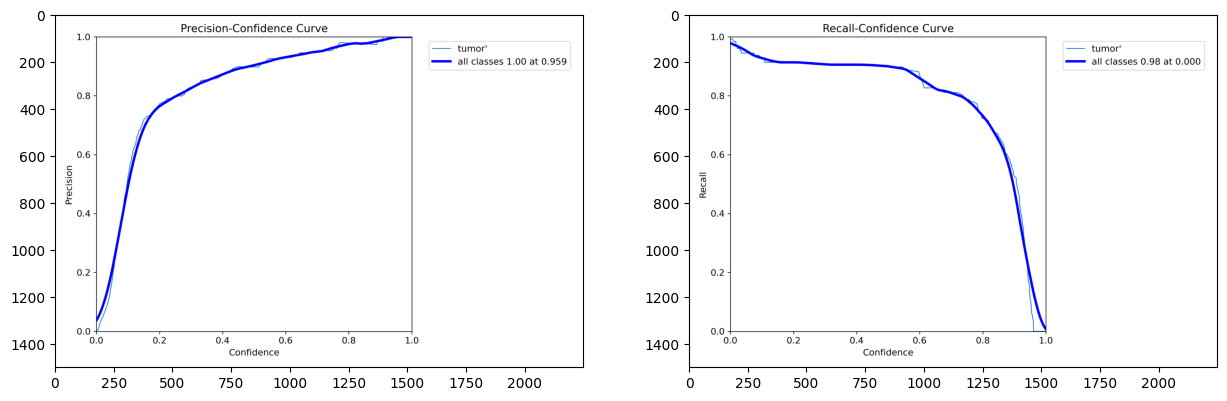

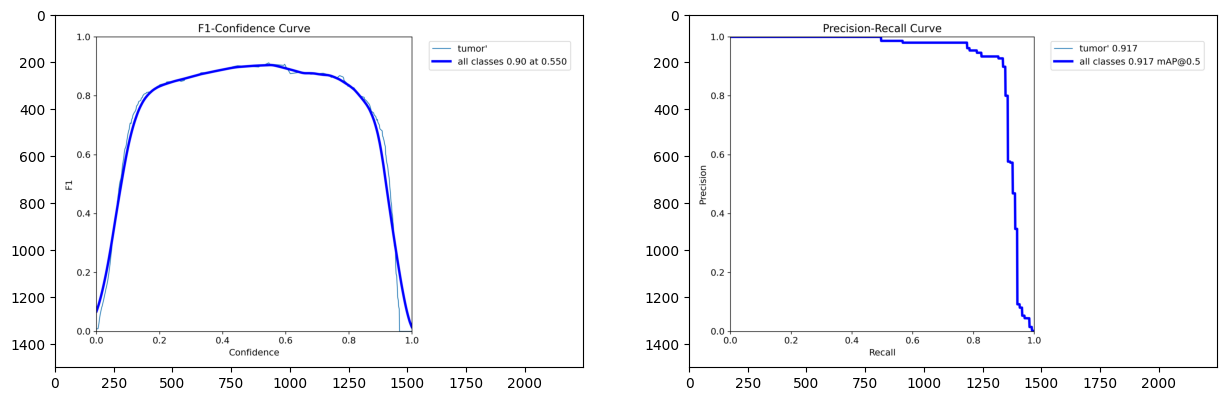

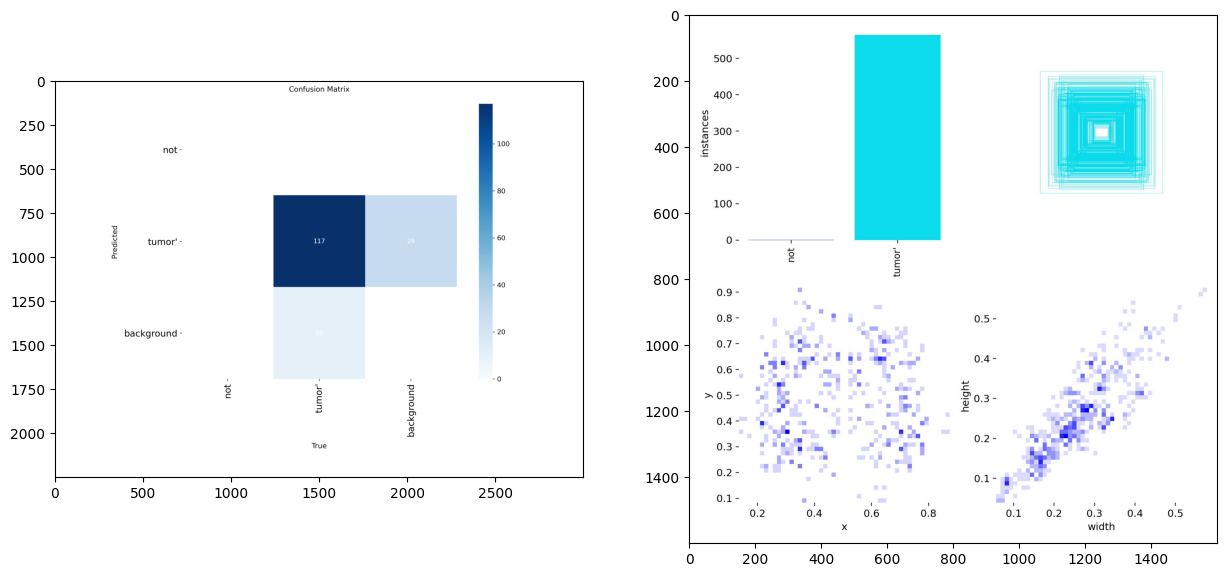

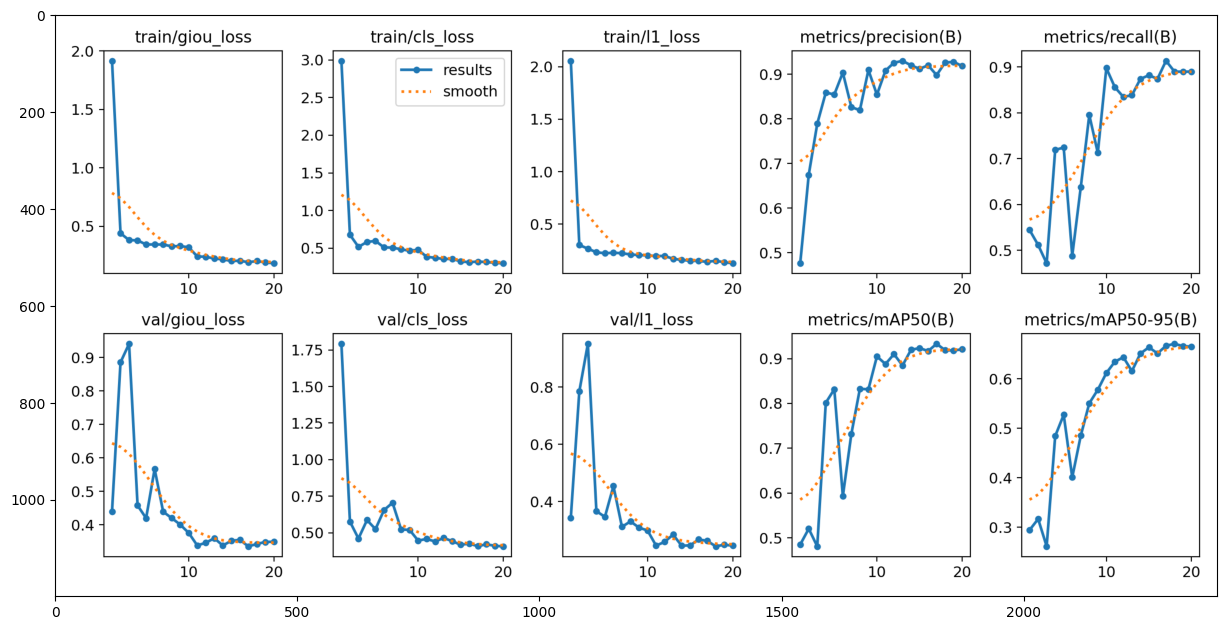

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
model_path = '/content/runs/detect/train4/'

def plot(ls, size):
    c=1
    plt.figure(figsize=(15,10))
    for im in ls:
        plt.subplot(size[0],size[1],c)
        im = plt.imread(model_path+im)
        plt.imshow(im)
        c+=1
    plt.show()

plot(['P_curve.png','R_curve.png'], (1,2))
plot(['F1_curve.png','PR_curve.png'], (1,2))
plot(['confusion_matrix.png','labels.jpg'], (1,2))
plot(['results.png'],(1,1))